In [5]:
from rdkit import Chem
import pyaniasetools as pya

from ase_interface import ANIENS,ensemblemolecule
import hdnntools as hdt
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
nets = dict()

ntdir = '/home/jsmith48/scratch/transfer_learning/train_ens_DFTTZ/'
nets['ANI-1x(DFTDZ)']= {'cns' : ntdir + 'rHCNO-4.6R_16-3.1A_a4-8.params',
                                 'sae' : ntdir + 'sae_linfit.dat',
                                 'nnf' : ntdir + 'train',
                                 'Nn'  : 5}

In [7]:
ens = ensemblemolecule(nets['ANI-1x(DFTDZ)']['cns'], nets['ANI-1x(DFTDZ)']['sae'], nets['ANI-1x(DFTDZ)']['nnf'], nets['ANI-1x(DFTDZ)']['Nn'], 0)

-119.98458089227644


/scratch/Gits/ase/ase/atoms.py:1358: UserWarning: Please use new API (which will return the angle in degrees): atoms_obj.get_dihedral(a1,a2,a3,a4)*pi/180 instead of atoms_obj.get_dihedral([a1,a2,a3,a4])
  'Please use new API (which will return the angle in degrees): '


Phi value (degrees), energy (kcal/mol)=  180.00 -117296.05
Phi value (degrees), energy (kcal/mol)=  175.00 -117295.98
Phi value (degrees), energy (kcal/mol)=  170.00 -117295.75
Phi value (degrees), energy (kcal/mol)=  165.00 -117295.41
Phi value (degrees), energy (kcal/mol)=  160.00 -117294.98
Phi value (degrees), energy (kcal/mol)=  155.00 -117294.47
Phi value (degrees), energy (kcal/mol)=  150.00 -117293.92
Phi value (degrees), energy (kcal/mol)=  145.00 -117293.36
Phi value (degrees), energy (kcal/mol)=  140.00 -117292.84
Phi value (degrees), energy (kcal/mol)=  135.00 -117292.41
Phi value (degrees), energy (kcal/mol)=  130.00 -117292.08
Phi value (degrees), energy (kcal/mol)=  125.00 -117291.89
Phi value (degrees), energy (kcal/mol)=  120.00 -117291.86
Phi value (degrees), energy (kcal/mol)=  115.00 -117291.97
Phi value (degrees), energy (kcal/mol)=  110.00 -117292.19
Phi value (degrees), energy (kcal/mol)=  105.00 -117292.56
Phi value (degrees), energy (kcal/mol)=  100.00 -117293.

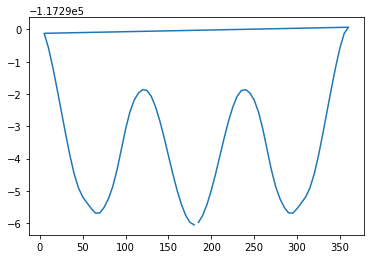

In [4]:
mol = Chem.MolFromMolFile('/auto/nest/nest/u/jsmith/Downloads/drugbank-1250.ipt.mol', removeHs=False)

ts = pya.ani_tortion_scanner(ens)
    
p,e = ts.scan_tortion(mol, [11,12,13,15], 5.0, 72)